/tmp/ipykernel_9597/156699292.py:18: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_9597/156699292.py:19: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or

<Figure size 1200x600 with 0 Axes>

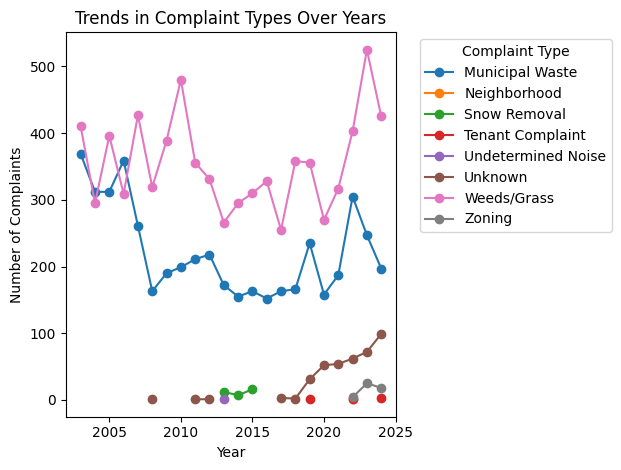

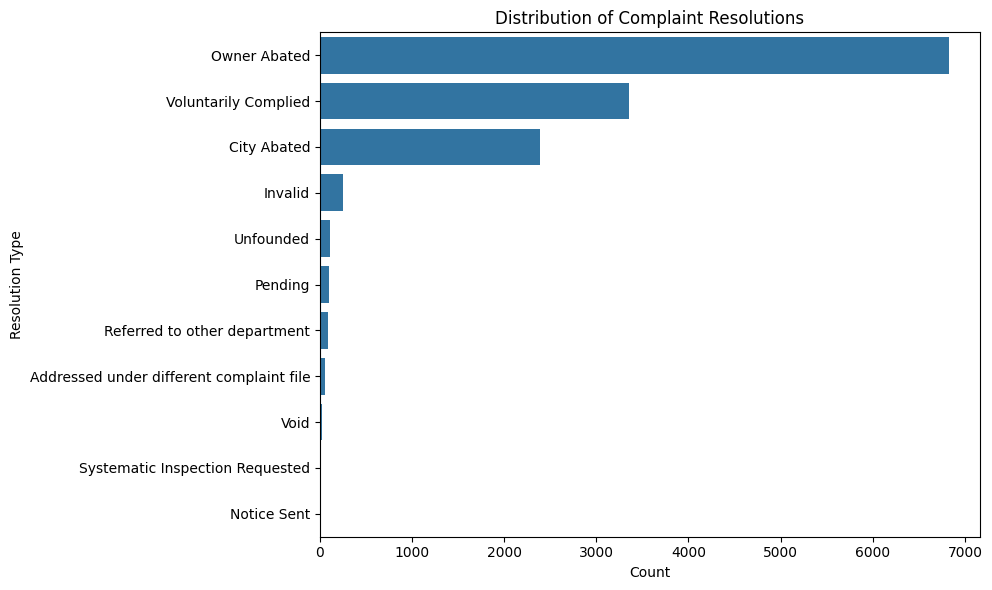

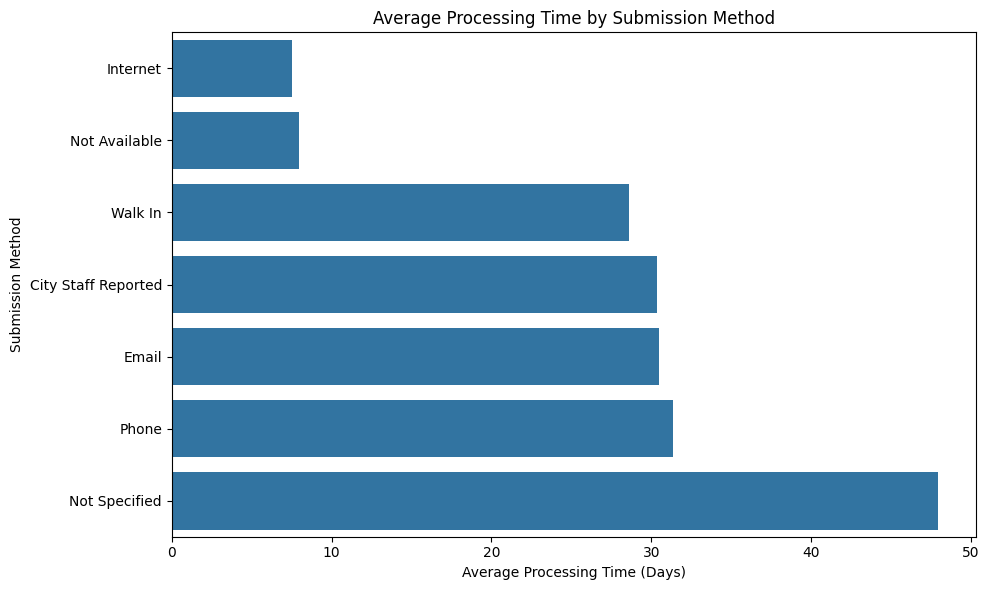

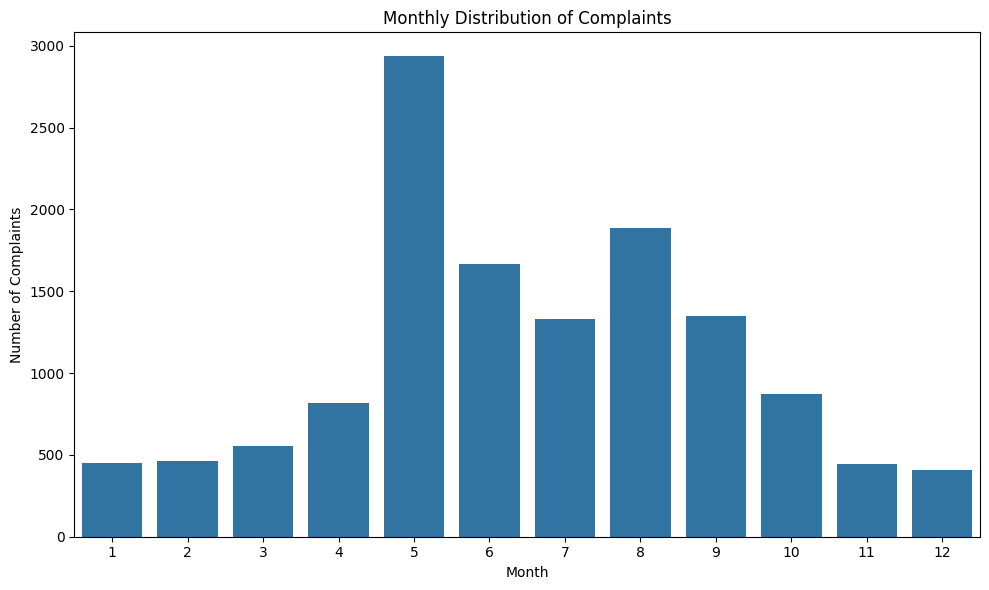

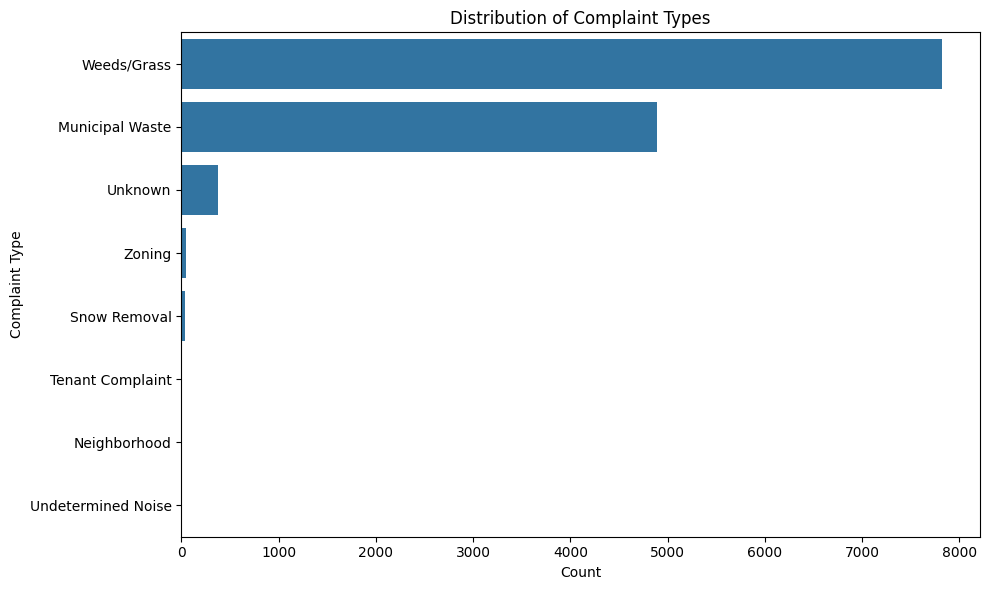

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# Load and clean data
def load_and_clean_data():
    data = pd.read_csv('./Nuisance_Complaints_20241130.csv')

    # Convert date columns
    date_columns = ['Date Reported', 'Date Notice Mailed or Given', 'File Close Date']
    for col in date_columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

    # Handle missing values
    data['Type of Complaint'].fillna('Unknown', inplace=True)
    data['Disposition'].fillna('Pending', inplace=True)
    data['Method Submitted'].fillna('Not Specified', inplace=True)

    # Calculate processing time
    data['Processing Time'] = (data['File Close Date'] - data['Date Reported']).dt.days

    # Remove duplicates
    data.drop_duplicates(subset=['File Number'], keep='first', inplace=True)

    return data

# Create visualizations
def create_visualizations(data):
    # 1. Complaint Types Over Time
    plt.figure(figsize=(12, 6))
    complaints_over_time = data.groupby(['Year Reported', 'Type of Complaint']).size().unstack()
    complaints_over_time.plot(kind='line', marker='o')
    plt.title('Trends in Complaint Types Over Years')
    plt.xlabel('Year')
    plt.ylabel('Number of Complaints')
    plt.legend(title='Complaint Type', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

    # 2. Resolution Distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, y='Disposition', order=data['Disposition'].value_counts().index)
    plt.title('Distribution of Complaint Resolutions')
    plt.xlabel('Count')
    plt.ylabel('Resolution Type')
    plt.tight_layout()
    plt.show()

    # 3. Average Processing Time by Submission Method
    plt.figure(figsize=(10, 6))
    avg_processing_time = data.groupby('Method Submitted')['Processing Time'].mean().sort_values()
    sns.barplot(x=avg_processing_time.values, y=avg_processing_time.index)
    plt.title('Average Processing Time by Submission Method')
    plt.xlabel('Average Processing Time (Days)')
    plt.ylabel('Submission Method')
    plt.tight_layout()
    plt.show()

    # 4. Monthly Distribution of Complaints
    plt.figure(figsize=(10, 6))
    monthly_complaints = data.groupby('Month Reported').size()
    sns.barplot(x=monthly_complaints.index, y=monthly_complaints.values)
    plt.title('Monthly Distribution of Complaints')
    plt.xlabel('Month')
    plt.ylabel('Number of Complaints')
    plt.tight_layout()
    plt.show()

    # 5. Complaint Type Distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, y='Type of Complaint',
                 order=data['Type of Complaint'].value_counts().index)
    plt.title('Distribution of Complaint Types')
    plt.xlabel('Count')
    plt.ylabel('Complaint Type')
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    # Load and clean data
    data = load_and_clean_data()

    # Create visualizations
    create_visualizations(data)

if __name__ == "__main__":
    main()

In [4]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set page config
st.set_page_config(page_title="Nuisance Complaints Dashboard", layout="wide")

# Title and introduction
st.title("Nuisance Complaints Analysis Dashboard")
st.markdown("**Team Members:** Shreyas Kulkarni (ssk16@illinois.edu) Vishal Devulapalli (nsd3@illinois.edu) Lu Chang (luchang2@illinois.edu)  Li Qiming (qimingl4@illinois.edu) Ruchita Alate (ralate2@illinois.edu) ")
st.write("This dashboard analyzes nuisance complaints data from the City of Urbana.")

# Load and clean data
@st.cache_data
def load_and_clean_data():
    # Load data
    data = pd.read_csv('./Nuisance_Complaints_20241130.csv')

    # Drop rows with missing File Number
    data = data.dropna(subset=['File Number'])

    # Handle Date Notice Mailed or Given
    data['Date Notice Mailed or Given'] = pd.to_datetime(data['Date Notice Mailed or Given'])
    data['Date Reported'] = pd.to_datetime(data['Date Reported'])
    median_delay = (data['Date Notice Mailed or Given'] - data['Date Reported']).dt.days.median()
    data['Date Notice Mailed or Given'].fillna(data['Date Reported'] + pd.to_timedelta(median_delay, unit='D'), inplace=True)

    # Handle Type of Complaint
    data['Type of Complaint'].fillna('Unknown', inplace=True)

    # Handle Disposition
    most_common_disposition = data.groupby('Type of Complaint')['Disposition'].apply(
        lambda x: x.mode()[0] if not x.mode().empty else 'Pending')
    data['Disposition'] = data.apply(
        lambda row: most_common_disposition[row['Type of Complaint']]
        if pd.isnull(row['Disposition']) else row['Disposition'], axis=1)

    # Handle File Close Date
    data['File Close Date'] = pd.to_datetime(data['File Close Date'], errors='coerce')

    # Calculate processing time only for resolved cases
    data['Processing Time'] = (data['File Close Date'] - data['Date Reported']).dt.days

    # Handle Method Submitted
    data['Method Submitted'] = data.apply(
        lambda row: 'Online' if row['Submitted Online?'] and pd.isnull(row['Method Submitted'])
        else row['Method Submitted'], axis=1)
    mode_method = data['Method Submitted'].mode()[0]
    data['Method Submitted'].fillna(mode_method, inplace=True)

    # Drop rows with missing Submitted Online?
    data = data.dropna(subset=['Submitted Online?'])

    # Handle Mapped Location
    data = data.dropna(subset=['Mapped Location'])

    # Extract latitude and longitude
    data['Latitude'] = data['Mapped Location'].str.extract(r'\(([^,]+),')[0].astype(float)
    data['Longitude'] = data['Mapped Location'].str.extract(r', ([^,]+)\)').astype(float)

    return data

# Load the data
try:
    data = load_and_clean_data()
    st.success("Data successfully loaded and cleaned!")
except Exception as e:
    st.error(f"Error loading data: {str(e)}")
    st.stop()

# Create sidebar
st.sidebar.header("Dashboard Controls")
selected_year = st.sidebar.selectbox(
    "Select Year",
    options=sorted(data['Year Reported'].unique()),
)

# Add visualization type selector
viz_type = st.sidebar.selectbox(
    "Select Visualization",
    ["Complaint Types", "Geographic Distribution", "Resolution Status",
     "Submission Methods", "Processing Time"]
)

# Filter data based on selected year
filtered_data = data[data['Year Reported'] == selected_year]

# Main content
st.header(f"Analysis for Year {selected_year}")

# Create metrics
col1, col2, col3 = st.columns(3)
with col1:
    st.metric("Total Complaints", len(filtered_data))
with col2:
    # Calculate average processing time only for resolved cases
    resolved_cases = filtered_data[filtered_data['File Close Date'].notna()]
    if len(resolved_cases) > 0:
        avg_process_time = resolved_cases['Processing Time'].mean()
        st.metric("Average Processing Time", f"{avg_process_time:.1f} days")
    else:
        st.metric("Average Processing Time", "N/A")
with col3:
    st.metric("Most Common Type", filtered_data['Type of Complaint'].mode()[0])


if viz_type == "Complaint Types":
    # Interactive Pie Chart
    st.subheader("Interactive Complaint Types Pie Chart")
    complaint_counts = filtered_data['Type of Complaint'].value_counts().reset_index()
    complaint_counts.columns = ['Complaint Type', 'Count']

    fig = px.pie(
        complaint_counts,
        names='Complaint Type',
        values='Count',
        title=f'Complaint Types Distribution in {selected_year}',
        hole=0.4  # Donut style
    )
    fig.update_traces(textinfo='percent+label')
    st.plotly_chart(fig, use_container_width=True)

elif viz_type == "Geographic Distribution":
    # Clustered Heatmap
    st.subheader("Clustered Heatmap of Complaints")
    map_center = [filtered_data['Latitude'].mean(), filtered_data['Longitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=12)

    heat_data = filtered_data[['Latitude', 'Longitude']].dropna().values.tolist()
    HeatMap(heat_data).add_to(m)

    st_data = st_folium(m, width=700, height=500)


elif viz_type == "Resolution Status":
    st.subheader("Complaint Resolution Status")
    fig, ax = plt.subplots(figsize=(10, 6))
    resolution_counts = filtered_data['Disposition'].value_counts()
    sns.barplot(x=resolution_counts.values, y=resolution_counts.index)
    plt.title(f'Resolution Status Distribution in {selected_year}')
    st.pyplot(fig)

elif viz_type == "Submission Methods":
    st.subheader("Submission Methods Analysis")
    fig, ax = plt.subplots(figsize=(10, 6))
    submission_counts = filtered_data['Method Submitted'].value_counts()
    sns.barplot(x=submission_counts.values, y=submission_counts.index)
    plt.title(f'Submission Methods in {selected_year}')
    st.pyplot(fig)


elif viz_type == "Processing Time":
    st.subheader("Processing Time Analysis")
    # Filter for resolved cases only
    resolved_data = filtered_data[filtered_data['File Close Date'].notna()]
    if len(resolved_data) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(data=resolved_data, x='Processing Time', bins=30)
        plt.title(f'Distribution of Processing Times in {selected_year}')
        plt.xlabel('Processing Time (Days)')
        st.pyplot(fig)
    else:
        st.write("No resolved cases in this period")

# Additional insights
st.header("Key Insights")
col1, col2 = st.columns(2)

with col1:
    st.subheader("Top 3 Complaint Types")
    top_complaints = filtered_data['Type of Complaint'].value_counts().head(3)
    st.write(top_complaints)

with col2:
    st.subheader("Resolution Efficiency")
    resolution_rate = (filtered_data['Disposition'].value_counts() /
                      len(filtered_data) * 100).round(2)
    st.write(resolution_rate)

# Footer
st.markdown("---")
st.markdown("Dataset provided by the City of Urbana Open Data Portal")

2024-12-04 15:16:40.951 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 15:16:40.951 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 15:16:40.952 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 15:16:40.952 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 15:16:40.953 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 15:16:40.953 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 15:16:40.954 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 15:16:40.954 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [6]:
data

,File Number,Date Reported,Year Reported,Month Reported,Housing Block,Street Name,Date Notice Mailed or Given,Type of Complaint,Disposition,File Close Date,Method Submitted,Submitted Online?,Total Fees,Mapped Location,Processing Time,Latitude,Longitude
0,24-001878,2024-06-21,2024,6,100 Block,West Mumford Drive,2024-06-21,Unknown,Unfounded,2024-06-24,Internet,True,0.0,"100 West Mumford Drive\nUrbana, IL\n(40.09413,...",3.0,40.09413,-88.20849
1,23-003307,2023-11-04,2023,11,300 Block,North Coler Avenue,2023-11-04,Unknown,Unfounded,2023-11-06,Internet,True,0.0,"300 North Coler Avenue\nUrbana, IL\n(40.11425,...",2.0,40.11425,-88.21578
2,23-001241,2023-05-11,2023,5,900 Block,South Rainbow View,2023-05-11,Weeds/Grass,Voluntarily Complied,2023-08-30,Phone,False,0.0,"900 South Rainbow View\nUrbana, IL\n(40.10555,...",111.0,40.10555,-88.18474
4,22-001582,2022-06-01,2022,6,700 Block,North Broadway Avenue,2022-06-01,Weeds/Grass,City Abated,2022-10-04,Phone,False,324.5,"700 North Broadway Avenue\nUrbana, IL\n(40.119...",125.0,40.11900,-88.20758
5,22-000450,2022-03-05,2022,3,600 Block,South Anderson Street,2022-03-05,Unknown,City Abated,2022-03-07,Internet,True,0.0,"600 South Anderson Street\nUrbana, IL\n(40.108...",2.0,40.10840,-88.20024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13206,23-002566,2023-08-30,2023,8,2000 Block,"South ""George Huff"" Drive",2023-08-30,Weeds/Grass,Voluntarily Complied,2023-09-07,Phone,False,0.0,"2000 South George Huff Drive\nUrbana, IL\n(40....",8.0,40.09365,-88.20265
13207,1110001,2011-10-03,2011,10,1300 BLOCK,N Berkley Av,2011-10-04,Weeds/Grass,City Abated,2011-10-12,Not Available,False,0.0,"1300 N Berkley Av\nUrbana, IL\n(40.12494, -88....",9.0,40.12494,-88.20650
13208,1201008,2012-01-12,2012,1,1200 BLOCK,N Division Av,2012-01-13,Weeds/Grass,Owner Abated,2012-01-21,Not Available,False,0.0,"1200 N Division Av\nUrbana, IL\n(40.12393, -88...",9.0,40.12393,-88.20533
13209,21-001175,2021-05-30,2021,5,1000 Block,West Hill Street,2021-05-30,Unknown,City Abated,2021-06-01,Internet,True,0.0,"1000 West Hill Street\nUrbana, IL\n(40.1192, -...",2.0,40.11920,-88.22122


In [ ]:
data.groupby("Year Reported")['Processing Time'].describe()


,count,mean,std,min,25%,50%,75%,max
Year Reported,,,,,,,,
2003,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,656.0,8.617378,1.352951,1.0,8.0,9.0,9.00,13.0
2008,463.0,5.663067,33.980942,-358.0,9.0,9.0,9.00,12.0
2009,541.0,7.635860,15.846092,-357.0,9.0,9.0,9.00,14.0
2010,638.0,8.557994,2.063876,-22.0,9.0,9.0,9.00,14.0
2011,541.0,8.502773,1.213539,0.0,8.0,9.0,9.00,11.0


In [19]:
data[data["Year Reported"]==2003]['Processing Time']

45      NaN
62      NaN
79      NaN
112     NaN
114     NaN
         ..
13141   NaN
13143   NaN
13195   NaN
13197   NaN
13204   NaN
Name: Processing Time, Length: 776, dtype: float64

In [16]:
data[data["Year Reported"]==2003]

,File Number,Date Reported,Year Reported,Month Reported,Housing Block,Street Name,Date Notice Mailed or Given,Type of Complaint,Disposition,File Close Date,Method Submitted,Submitted Online?,Total Fees,Mapped Location,Processing Time,Latitude,Longitude
45,305073,2003-05-14,2003,5,1400 BLOCK,S Lincoln Av,2003-05-14,Municipal Waste,City Abated,NaT,Not Available,False,0.0,"1400 S Lincoln Av\nUrbana, IL\n(40.10051, -88....",NaN,40.10051,-88.21913
62,304009,2003-04-15,2003,4,1500 BLOCK,N Romine,2003-04-15,Municipal Waste,Owner Abated,NaT,Not Available,False,0.0,"1500 N Romine\nUrbana, IL\n(40.12644, -88.22763)",NaN,40.12644,-88.22763
79,304022,2003-04-28,2003,4,1000 BLOCK,N Geraldine Av,2003-04-28,Weeds/Grass,City Abated,NaT,Not Available,False,0.0,"1000 N Geraldine Av\nUrbana, IL\n(40.12211, -8...",NaN,40.12211,-88.20280
112,302035,2003-02-13,2003,2,700 BLOCK,W Ohio St,2003-02-13,Municipal Waste,Owner Abated,NaT,Not Available,False,0.0,"700 W Ohio St\nUrbana, IL\n(40.10371, -88.21712)",NaN,40.10371,-88.21712
114,302006,2003-02-04,2003,2,600 BLOCK,W Nevada,2003-02-04,Municipal Waste,Owner Abated,NaT,Not Available,False,0.0,"600 W Nevada\nUrbana, IL\n(40.10653, -88.21554)",NaN,40.10653,-88.21554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13141,312023,2003-12-08,2003,12,1400 BLOCK,S Adams,2003-12-08,Municipal Waste,Owner Abated,NaT,Not Available,False,0.0,"1400 S Adams\nUrbana, IL\n(40.09948, -88.18815)",NaN,40.09948,-88.18815
13143,301031,2003-01-28,2003,1,900 BLOCK,N Coler Av,2003-01-28,Municipal Waste,Owner Abated,NaT,Not Available,False,0.0,"900 N Coler Av\nUrbana, IL\n(40.12025, -88.21569)",NaN,40.12025,-88.21569
13195,303063,2003-03-28,2003,3,1200 BLOCK,W Eads St,2003-03-28,Municipal Waste,Owner Abated,NaT,Not Available,False,0.0,"1200 W Eads St\nUrbana, IL\n(40.12313, -88.22435)",NaN,40.12313,-88.22435
13197,309049,2003-09-18,2003,9,500 BLOCK,N Cunningham Av,2003-09-18,Weeds/Grass,Owner Abated,NaT,Not Available,False,0.0,"500 N Cunningham Av\nUrbana, IL\n(40.11683, -8...",NaN,40.11683,-88.20473
